# Testing the Engine Model on Real World Data

## Jessica Stinson
## s224576666

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

# Set TensorFlow environment
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Standard libraries 
import datetime
import functools
from functools import lru_cache
import hashlib
import io
import json
import math
import random
import time
from pathlib import Path
from platform import python_version

# Data and numerical libraries 
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Audio handling 
import soundfile as sf
import librosa

# Machine learning
import tensorflow as tf
import tensorflow_hub as hub

# Audio augmentation
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Caching
import diskcache as dc

# Version info
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('TensorFlow hub Version   : ', hub.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

Python Version           :  3.9.21
TensorFlow Version       :  2.10.0
TensorFlow hub Version   :  0.12.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.40.0


In [3]:
# Applying system constraints
SC = {
    'AUDIO_DATA_DIRECTORY': r"C:\Project-Echo\src\Prototypes\data\Data Files\Bucket 3",
    'CACHE_DIRETORY': r"C:\Project-Echo\src\Prototypes\engine\Optimising for Low Frequency Audio\cache",

    'AUDIO_CLIP_DURATION': 5, # seconds 
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 48000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 20,
    'CLASSIFIER_BATCH_SIZE': 16,
    'MAX_EPOCHS': 50,
}

In [4]:
def enforce_memory_limit(mem_mb):

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)

In [5]:
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 

def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func

In [6]:
def paths_and_labels_to_dataset(audio_paths, labels, num_classes):
    one_hot_labels = tf.one_hot(labels, depth=num_classes)

    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(one_hot_labels)

    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    
    return zipped_path_ds

# Function to index directories and extract class names and file paths
def index_directory(directory, file_types=('.ogg', '.mp3', '.wav', '.flac')):
    audio_files = []
    labels = []
    class_names = sorted([dir.name for dir in Path(directory).glob('*') if dir.is_dir()])
    for label, class_name in enumerate(class_names):
        class_dir = Path(directory) / class_name
        for file_path in class_dir.glob(f'**/*'):
            if file_path.suffix in file_types:
                audio_files.append(str(file_path))
                labels.append(label)  # Store the integer label instead of the class name
    return audio_files, labels, class_names

# Function to create the datasets
def create_datasets(audio_dir, train_split=0.8, val_split=0.19, split_file = None, save_splits_to = None):
    # Check for a split file and load dataset splits if available
    if split_file:
        print("Loading dataset splits from saved file")
        with open(split_file, "r") as f:
            data = json.load(f)
        file_paths, labels = zip(*data["all_data"])
        file_paths = list(file_paths)
        labels = list(labels)
        class_names = data["class_names"]

    else:
        # create new dataset splits if a split file is not available
        print("Creating new dataset splits")
        file_paths, labels, class_names = index_directory(audio_dir)
    
        all_data = list(zip(file_paths, labels))

        random.seed(42)
        random.shuffle(all_data)

        file_paths, labels = zip(*all_data)
        file_paths = list(file_paths)
        labels = list(labels)

        # Save splits for future use and distribution 
        if save_splits_to:
            os.makedirs(os.path.dirname(save_splits_to), exist_ok=True)
            with open(save_splits_to, "w") as f:
                json.dump({
                    "all_data": list(zip(file_paths, labels)),
                    "class_names": class_names
                }, f, indent=2)
        
    dataset = paths_and_labels_to_dataset(
        audio_paths=file_paths,
        labels=labels,
        num_classes=len(class_names)
    )
    
    dataset = dataset.shuffle(len(file_paths), seed=42)

    dataset_size = len(file_paths)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds, class_names

# Verify the audio directory exists and contains files
audio_dir = Path(SC['AUDIO_DATA_DIRECTORY'])
if not audio_dir.exists():
    print(f"Directory does not exist: {audio_dir}")
else:
    audio_files = list(audio_dir.glob('**/*'))
    print(f"Audio files found: {len(audio_files)}")
    if len(audio_files) == 0:
        raise ValueError(f"No audio files found in directory: {audio_dir}")

Audio files found: 7654


In [7]:
# create the training, validation and test datasets
split_file = "./saved_splits/my_split.json"

if os.path.exists(split_file):
    train_ds, val_ds, test_ds, class_names = create_datasets(SC['AUDIO_DATA_DIRECTORY'], split_file=split_file)
else:
    print("Creating new dataset splits...")
    train_ds, val_ds, test_ds, class_names = create_datasets(
        SC['AUDIO_DATA_DIRECTORY'],
        train_split=0.8, 
        val_split=0.19,
        save_splits_to="./saved_splits/my_split.json"
    )
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Loading dataset splits from saved file
Class names:  ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates le

In [8]:
def python_load_and_decode_file(sample, label, variant, cache_key, cache_found):
    try:
        if cache_found == np.int32(0):
            tmp_audio_t = None
            
            with open(sample, 'rb') as file:
                # Load the audio data with librosa
                tmp_audio_t, _ = librosa.load(file, sr=SC['AUDIO_SAMPLE_RATE'])

                # Process stereo files to mono
                if tmp_audio_t.ndim == 2:
                    tmp_audio_t = tmp_audio_t[1, :]
                    
                tmp_audio_t = tmp_audio_t.astype(np.float32)
                assert(tmp_audio_t is not None)
                assert(isinstance(tmp_audio_t, np.ndarray))
                
            sample = tmp_audio_t
        else:
            sample = cache[cache_key.decode('utf-8')]

    except Exception as e:
        print(f"Error loading file {sample}: {e}")
        sample = np.zeros(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'], dtype=np.float32)
    
    return sample, label, variant, cache_key, cache_found

In [9]:
def tensorflow_load_random_subsection(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        duration_secs = SC['AUDIO_CLIP_DURATION']
        
        # Determine the audio file's duration in seconds
        audio_duration_secs = tf.shape(sample)[0] / SC['AUDIO_SAMPLE_RATE']
        
        if audio_duration_secs>duration_secs:
        
            # Calculate the starting point of the 5-second subsection
            max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
            start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
            
            start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)
    
            # Load the 5-second subsection
            end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)
            
            subsection = sample[start_index : end_index]
        
        else:
            # Pad the subsection with silence if it's shorter than 5 seconds
            padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(sample)[0]
            padding = tf.zeros([padding_length], dtype=sample.dtype)
            subsection = tf.concat([sample, padding], axis=0)

        sample = subsection

    return sample, label, variant, cache_key, cache_found

In [10]:
# Audio augmentation pipeline
def python_audio_augmentations(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        # See https://github.com/iver56/audiomentations for more options
        augmentations = Compose([
            # Add Gaussian noise with a random amplitude to the audio
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

            # Time-stretch the audio without changing its pitch
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

            # Shift the pitch of the audio within a range of semitones
            PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

            # Shift the audio in time by a random fraction
            Shift(min_shift=-0.5, max_shift=0.5, p=0.2),
        ])
        
        # apply audio augmentation to the clip
        sample = augmentations(samples=sample, sample_rate=SC['AUDIO_SAMPLE_RATE'])
    
    return sample, label, variant, cache_key, cache_found

In [11]:
# Image augmentation pipeline (updated to remove tf.contrib)
def tensorflow_image_augmentations(sample, label, variant, cache_key, cache_found):
    if cache_found == np.int32(0):
        # Random rotation -2 deg to 2 deg
        degrees = tf.random.uniform(shape=(), minval=-2, maxval=2)

        # Convert the angle to radians
        radians = degrees * math.pi / 180.0

        # Define the transformation matrix for rotation
        def angles_to_projective_transforms(angle, image_height, image_width):
            """Creates a transformation matrix for the given angle."""
            cos_val = tf.cos(angle)
            sin_val = tf.sin(angle)
            transform = [
                cos_val, -sin_val, 0.0,
                sin_val, cos_val, 0.0,
                0.0, 0.0
            ]
            return tf.convert_to_tensor(transform, dtype=tf.float32)

        # Generate the transformation matrix
        rotation_matrix = angles_to_projective_transforms(radians, tf.shape(sample)[0], tf.shape(sample)[1])

        # Apply the rotation using the transformation matrix
        sample = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(sample, 0),  # Add batch dimension
            transforms=tf.expand_dims(rotation_matrix, 0),  # Expand dims for batch
            output_shape=tf.shape(sample)[:2],  # Ensure only height and width
            interpolation="BILINEAR"
        )
        # Remove the batch dimension
        sample = tf.squeeze(sample, 0)

    return sample, label, variant, cache_key, cache_found

In [12]:
# Create melspectrograms
def python_dataset_melspectro_pipeline(sample, label, variant, cache_key, cache_found, min_freq=None, max_freq=None):

    if cache_found == np.int32(0):
        # Compute the mel-spectrogram
        image = librosa.feature.melspectrogram(
            y=sample, 
            sr=SC['AUDIO_SAMPLE_RATE'], 
            n_fft=SC['AUDIO_NFFT'], 
            hop_length=SC['AUDIO_STRIDE'], 
            n_mels=SC['AUDIO_MELS'],
            fmin=SC['AUDIO_FMIN'],
            fmax=SC['AUDIO_FMAX'],
            win_length=SC['AUDIO_WINDOW'])

        # Optionally convert the mel-spectrogram to decibel scale
        image = librosa.power_to_db(
            image, 
            top_db=SC['AUDIO_TOP_DB'], 
            ref=1.0)

         # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
            
        mel_freqs = librosa.mel_frequencies(
                n_mels=SC['AUDIO_MELS'],
                fmin=SC['AUDIO_FMIN'],
                fmax=SC['AUDIO_FMAX'])
        
        # Apply random frequency masking 
        if min_freq is not None and max_freq is not None:
            mask = (mel_freqs >= min_freq) & (mel_freqs < max_freq)
            image[mask, :] = 0
        elif random.random() < 0.25:
            start_freq_options = range(0, 12001, 1000)  # Possible starting frequencies (0, 1000, 2000, ..., 12000)
            if start_freq_options:
                min_freq = random.choice(start_freq_options)
                max_freq = min_freq + 1000
                mask = (mel_freqs >= min_freq) & (mel_freqs < max_freq)
                image[mask, :] = 0
        image = np.moveaxis(image, 1, 0)
        sample = image[0:expected_clip_samples,:]
             
    return sample, label, variant, cache_key, cache_found


def tensorflow_reshape_image_pipeline(sample, label, variant, cache_key, cache_found):   
    
    if cache_found == np.int32(0):
        # reshape into standard 3 channels to add the color channel
        image = tf.expand_dims(sample, -1)
        
        image = tf.repeat(image, SC['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)
        
        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
        
        # calculate the image shape and ensure it is correct   
        image = tf.ensure_shape(image, [expected_clip_samples, SC['AUDIO_MELS'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
        
        # resize the image to match model image input size
        image = tf.image.resize(image, (SC['MODEL_INPUT_IMAGE_WIDTH'],SC['MODEL_INPUT_IMAGE_HEIGHT']), 
                                method=tf.image.ResizeMethod.LANCZOS5)

        # rescale to range [0,1]
        image = image - tf.reduce_min(image) 
        sample = image / (tf.reduce_max(image)+0.0000001)
    
    return sample, label, variant, cache_key, cache_found

In [13]:
def tensorflow_add_variant_and_cache(path, label):
    variant     = tf.random.uniform(shape=(), minval=0, maxval=SC['SAMPLE_VARIANTS'], dtype=tf.int32)
    sample      = path
    cache_key   = b'no key'
    cache_found = np.int32(0)
    return sample, label, variant, cache_key, cache_found

def tensorflow_drop_variant_and_cache(sample, label, variant, cache_key, cache_found):
    return sample, label

def tensorflow_output_shape_setter(sample, label, variant, cache_key, cache_found):
    global class_names
    sample.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([len(class_names),]) 
    return sample, label, variant, cache_key, cache_found

In [14]:
def python_fuction_wrapper(pipeline_fn, out_types, sample, label, variant, cache_key, cache_found, **kwargs):
    if pipeline_fn.__name__ == 'python_dataset_melspectro_pipeline_fine_tune':
        # Pass the extra keyword arguments to the target function
        sample, label, variant, cache_key, cache_found = tf.numpy_function(
            func=lambda v1, v2, v3, v4, v5, min_freq_remove=None, max_freq_remove=None:
                pipeline_fn(v1, v2, v3, v4, v5, min_freq_remove=kwargs.get('min_freq_remove'), max_freq_remove=kwargs.get('max_freq_remove')),
            inp=(sample, label, variant, cache_key, cache_found),
            Tout=out_types)
    else:
        # For other functions, pass only the standard positional arguments
        sample, label, variant, cache_key, cache_found = tf.numpy_function(
            func=lambda v1, v2, v3, v4, v5: pipeline_fn(v1, v2, v3, v4, v5),
            inp=(sample, label, variant, cache_key, cache_found),
            Tout=out_types)
    return sample, label, variant, cache_key, cache_found

In [15]:
def python_disk_cache_start(sample, label, variant, cache_key, cache_found):

    cache_key   = b'no key'
    cache_found = np.int32(0)
    
    if SC['USE_DISK_CACHE']:
        _,cache_key,_ = create_function_key(python_disk_cache_start, sample, label, variant)
        if cache_key in cache:
            cache_found = np.int32(1)
        else:
            pass
            
    return sample, label, variant, cache_key, cache_found

def python_disk_cache_end(sample, label, variant, cache_key, cache_found):
    cache_key = cache_key.decode('utf-8')
    if SC['USE_DISK_CACHE']:
        if cache_found == np.int32(0):
            cache[cache_key] = sample
            
    return sample, label, variant, cache_key, cache_found

In [16]:
# Get the length of the training dataset
len_train_ds = len(train_ds)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)

# Create the training dataset pipeline
train_dataset = (train_ds
                 .shuffle(len_train_ds)
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 #.cache()
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

In [17]:
# Create the validation dataset pipeline
validation_dataset = (val_ds
                    .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls) 
                    .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    #.cache() # Use TensorFlow's in-memory cache
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

In [18]:
# Create the test dataset pipeline
test_dataset = (test_ds
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_fuction_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

 sample info: (16, 260, 260, 3), 
 label info: (16, 118) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


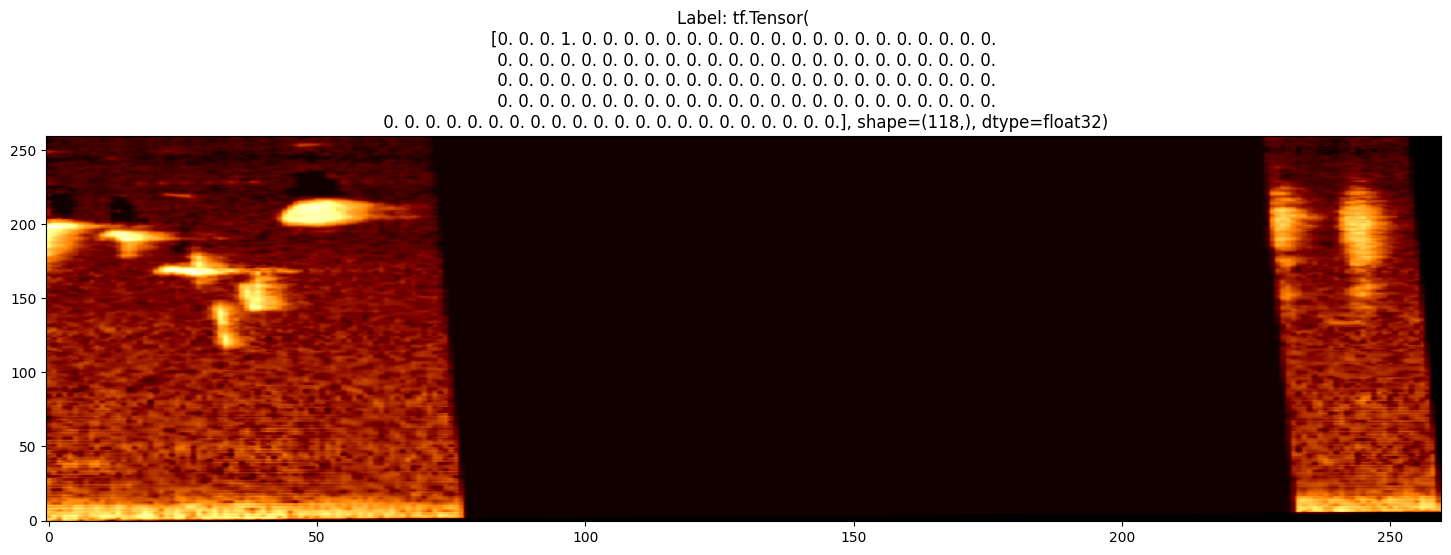

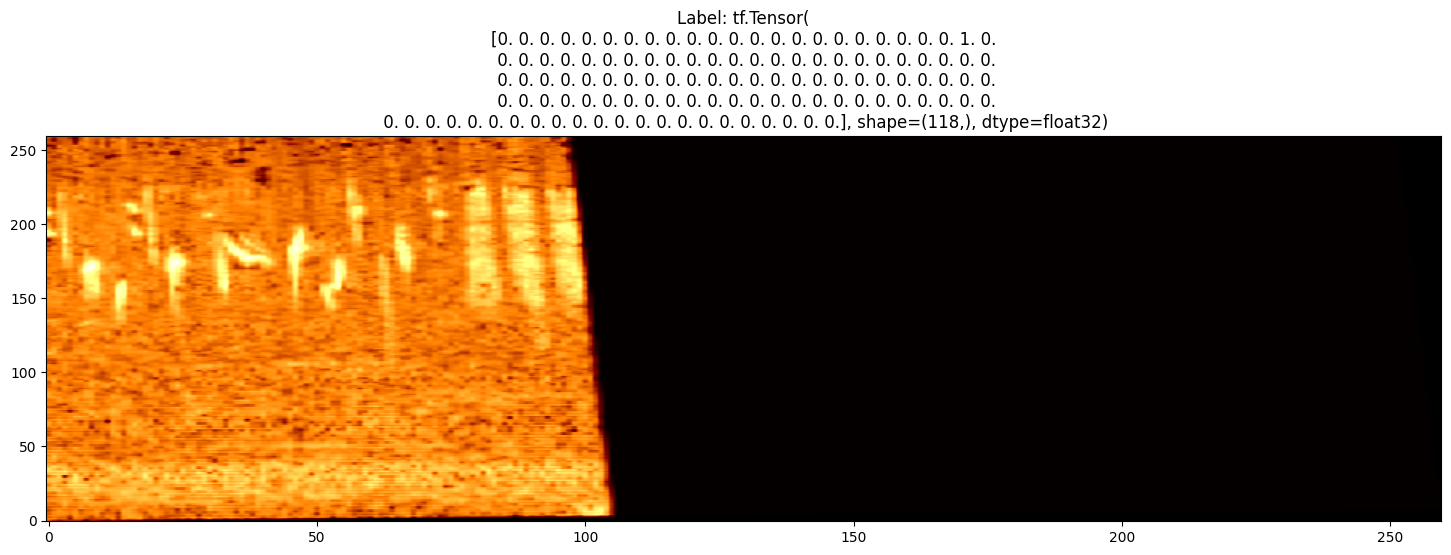

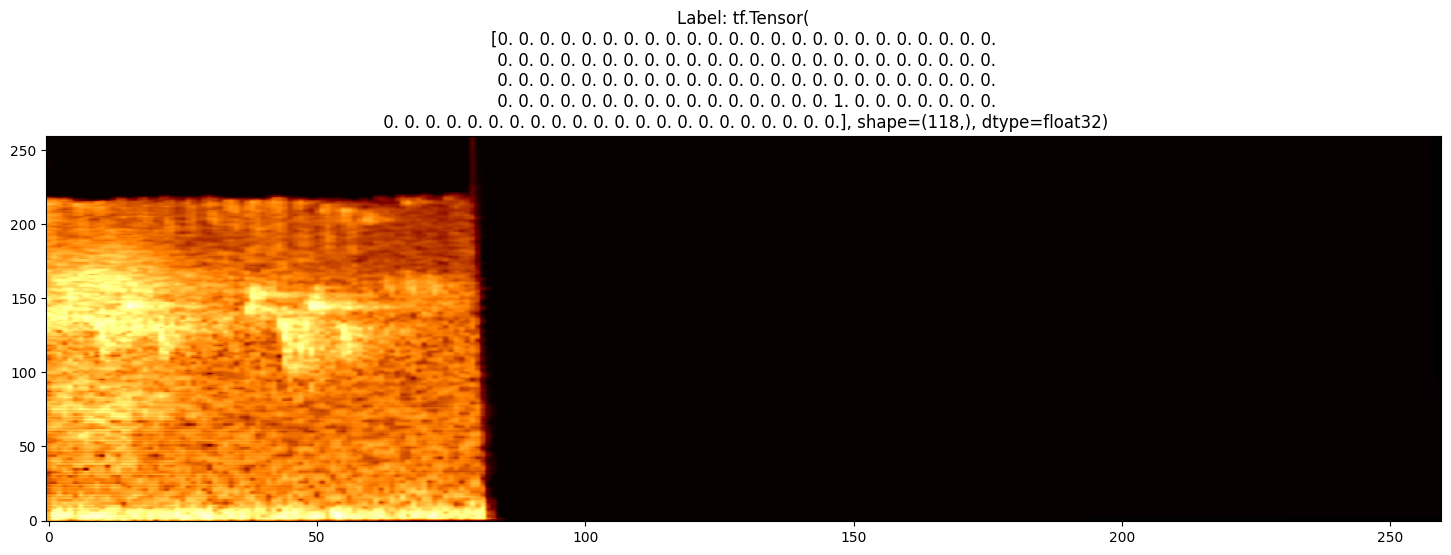

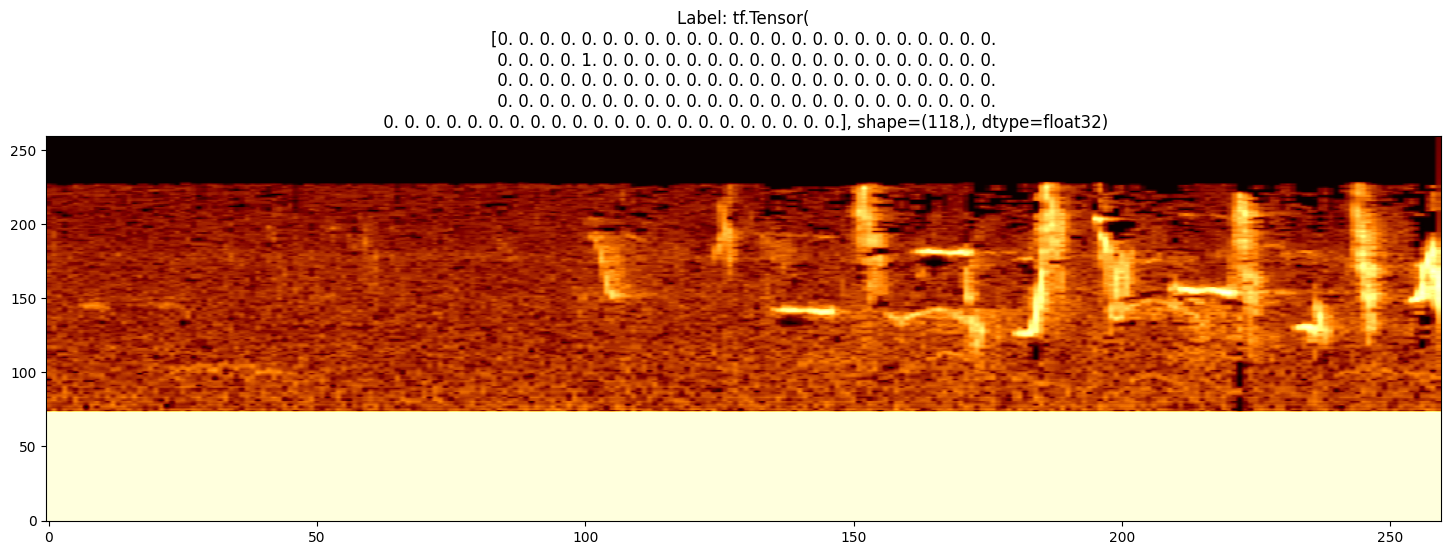

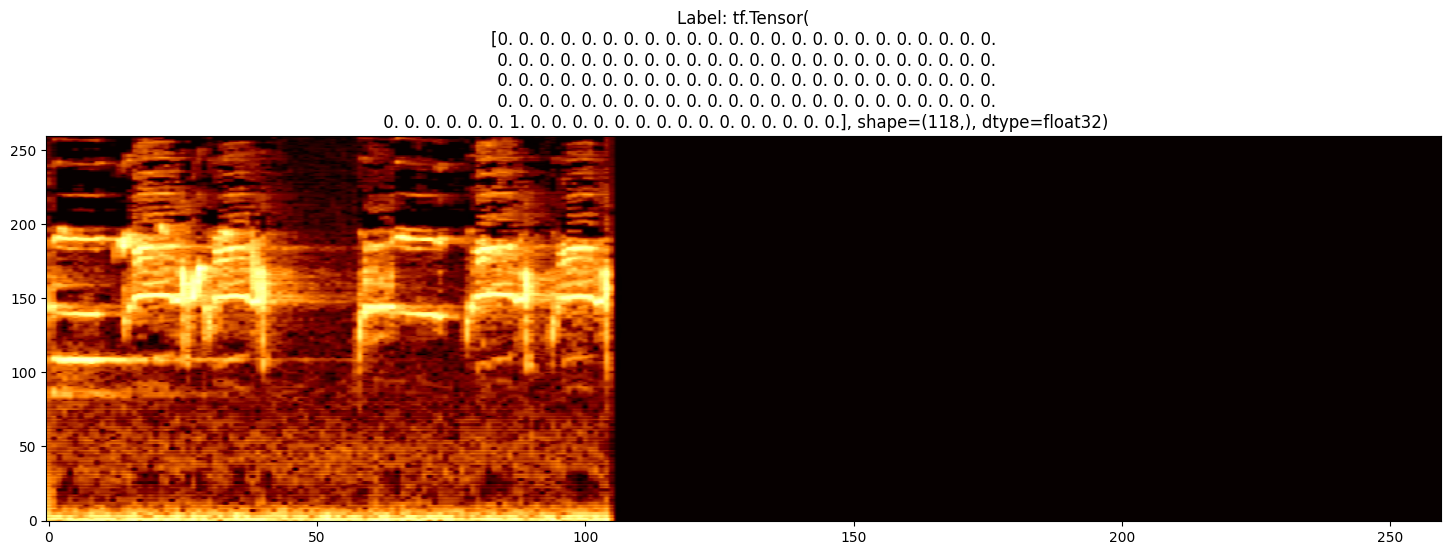

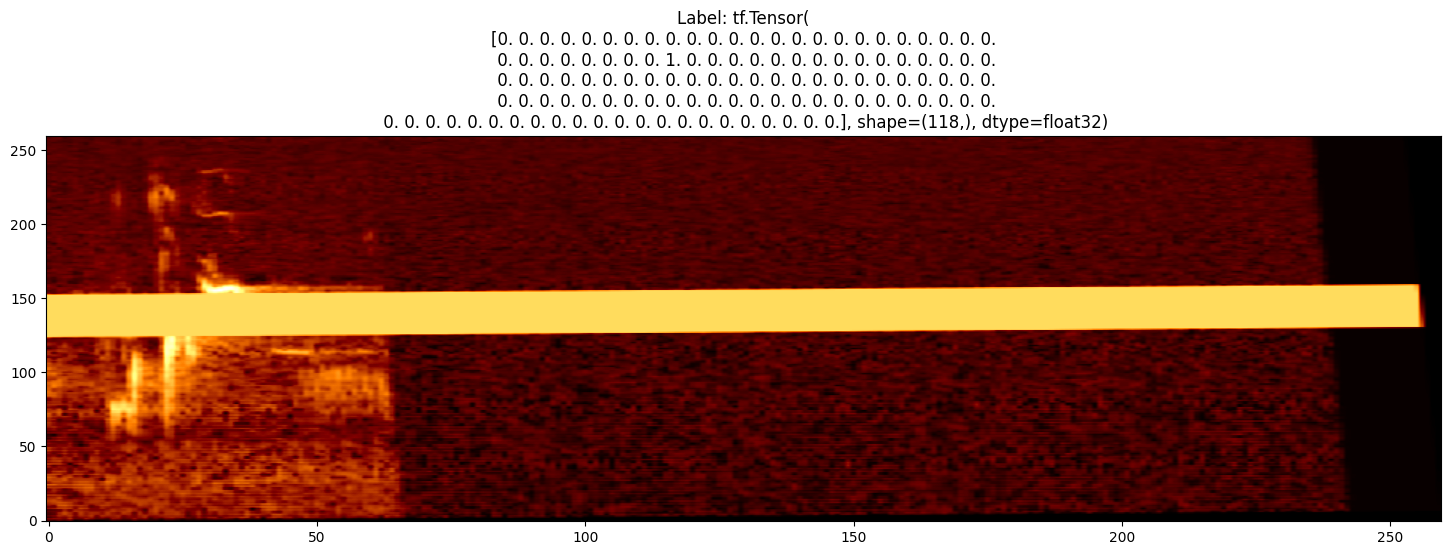

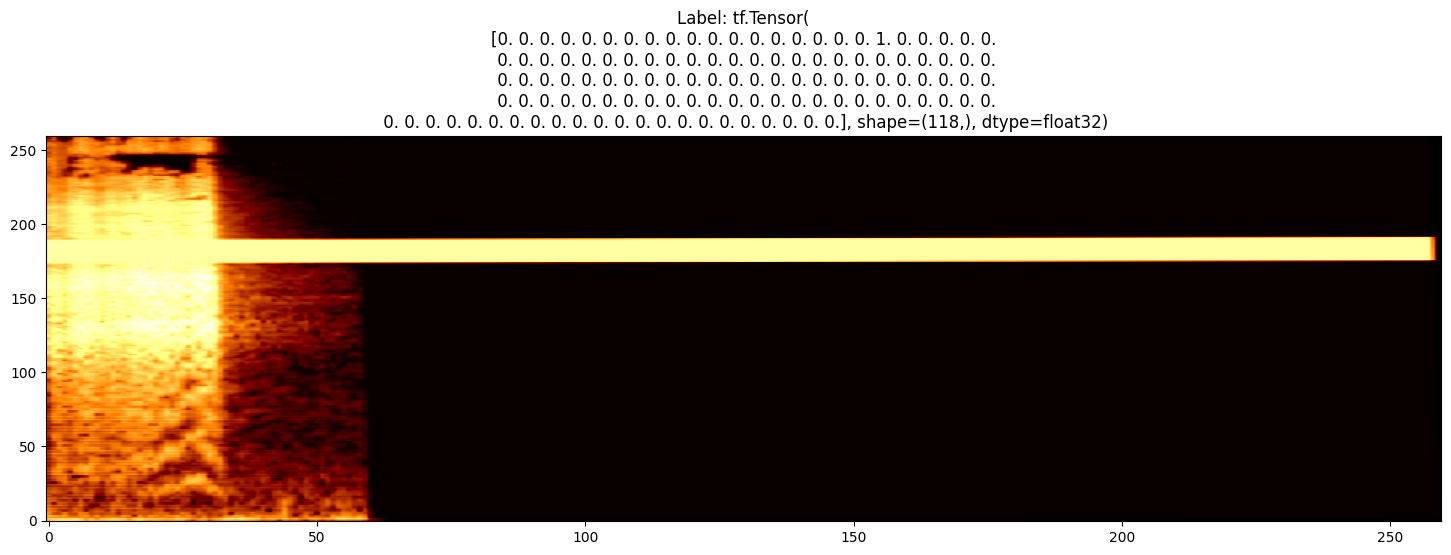

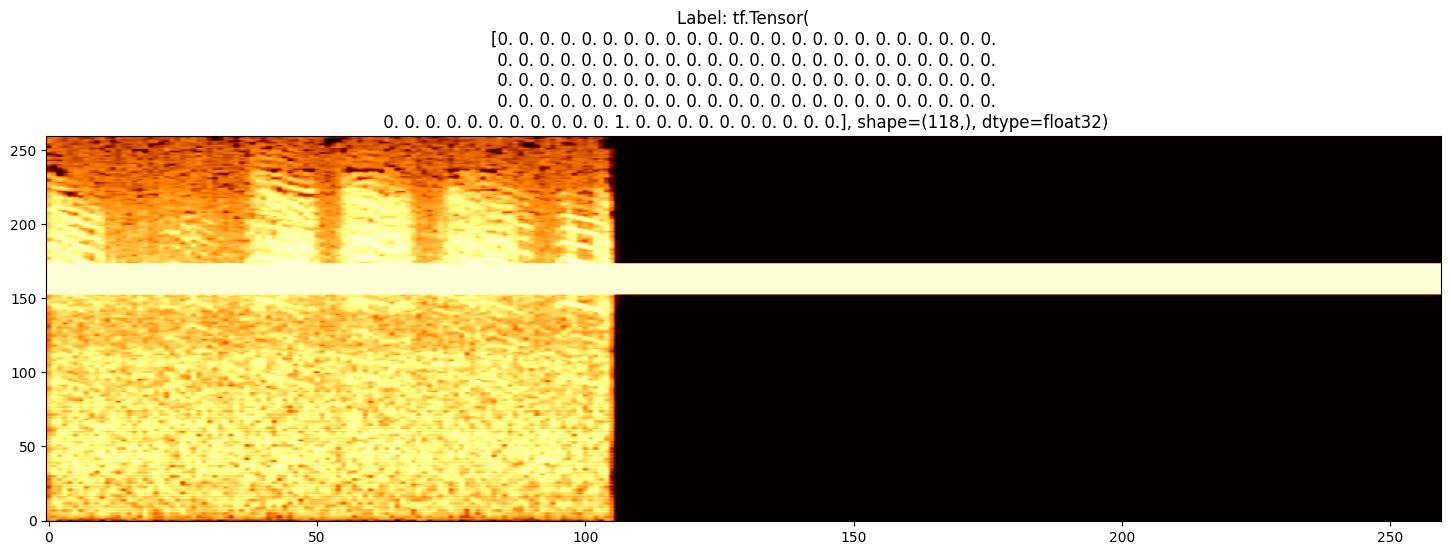

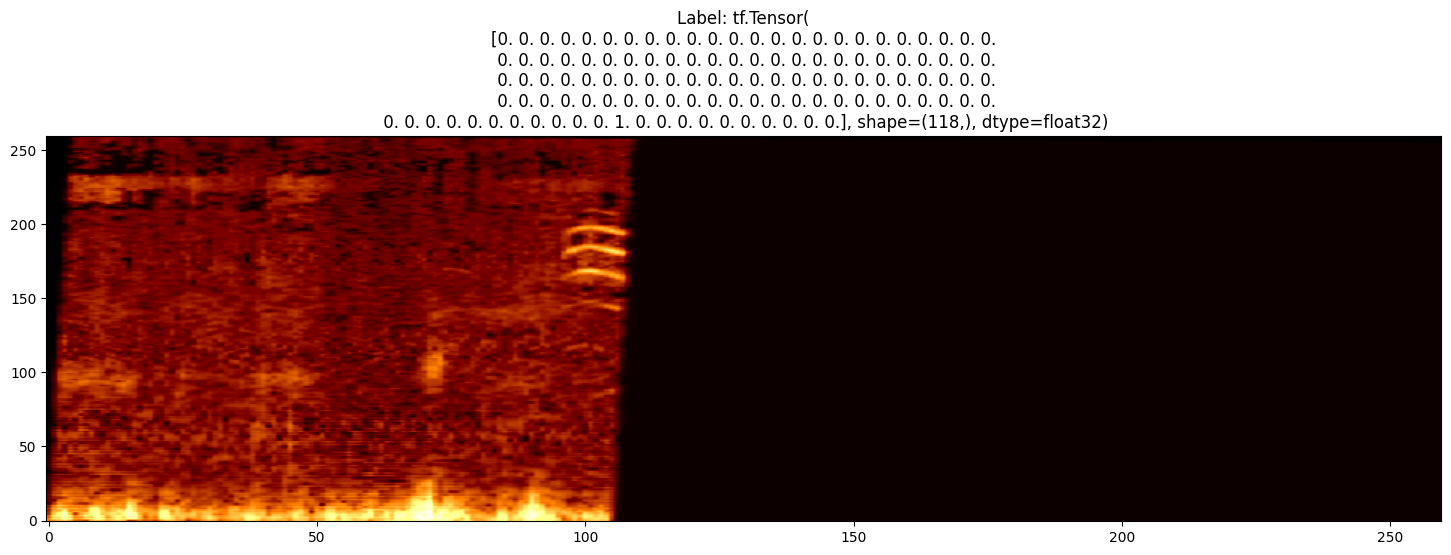

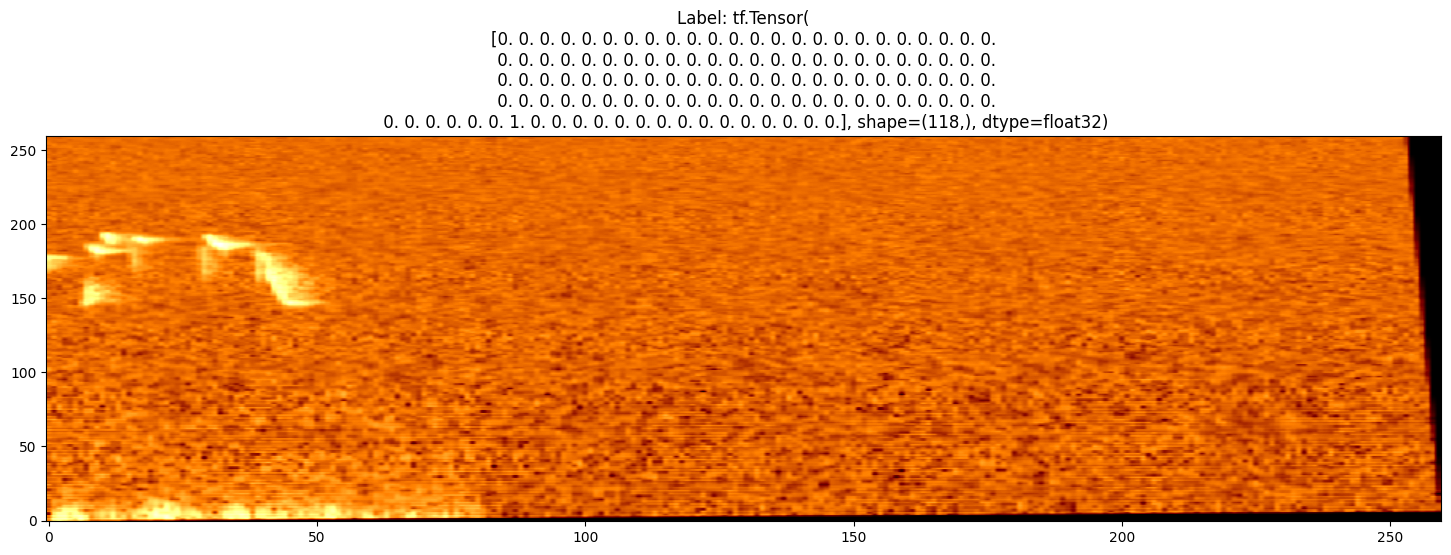

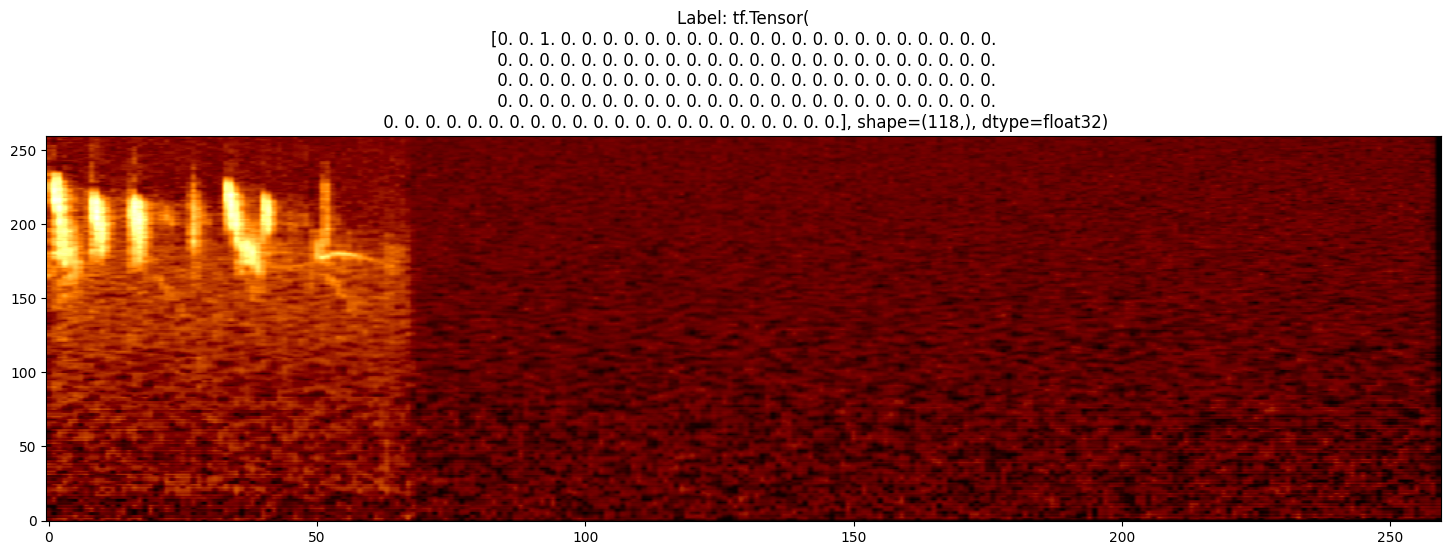

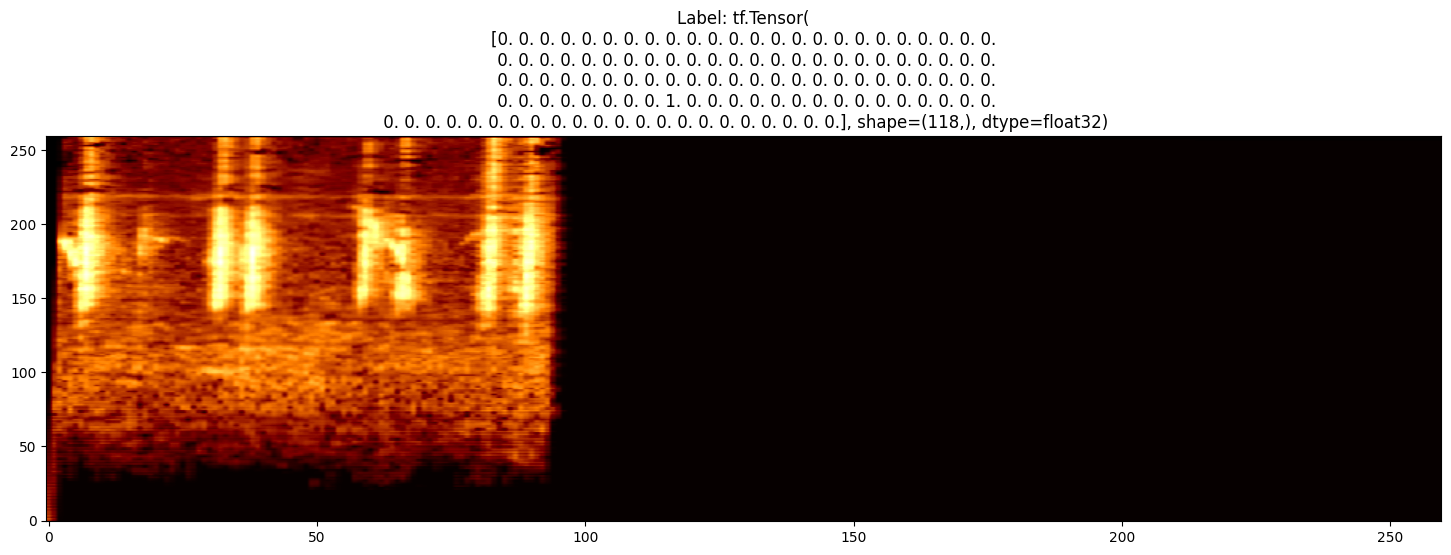

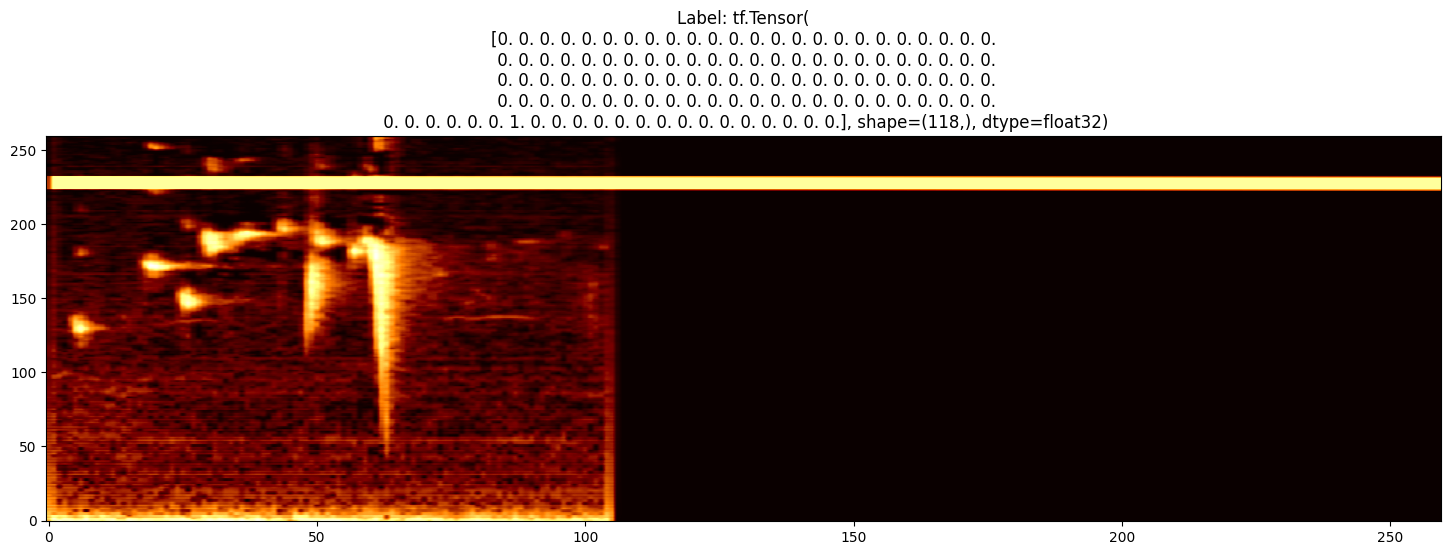

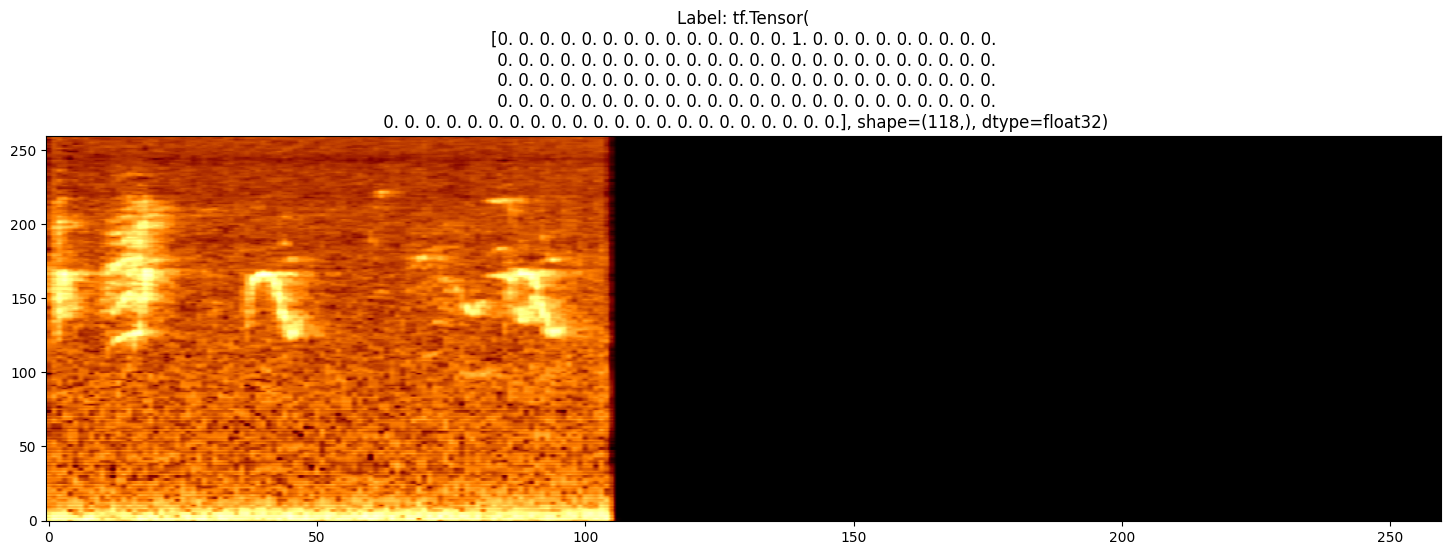

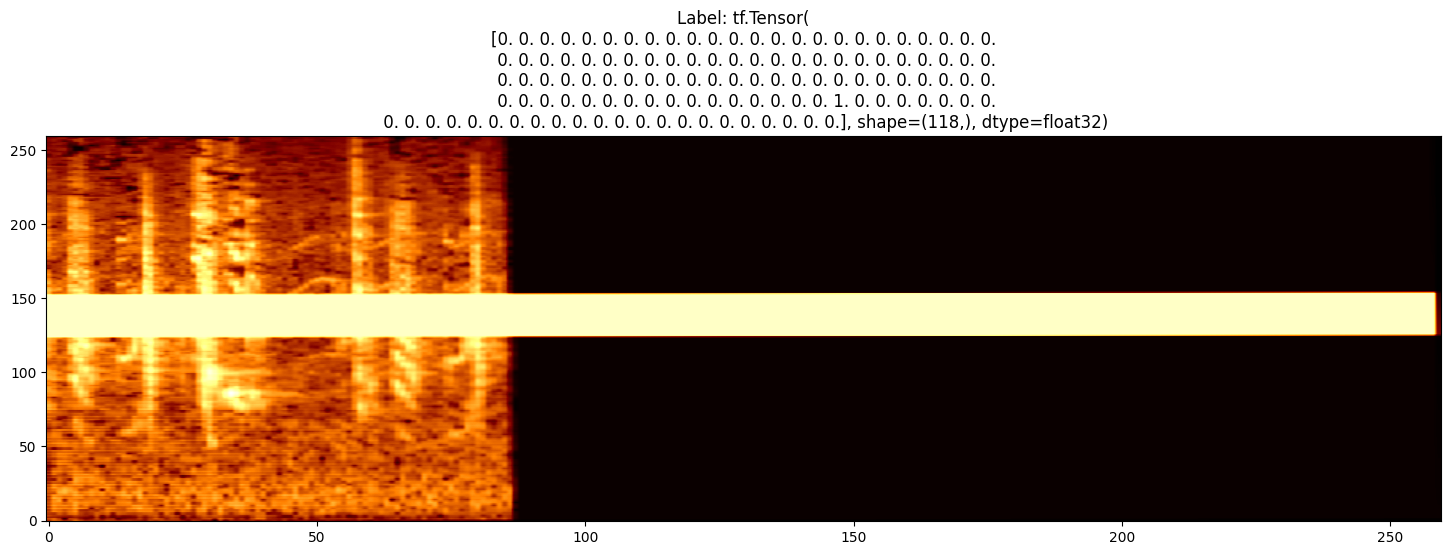

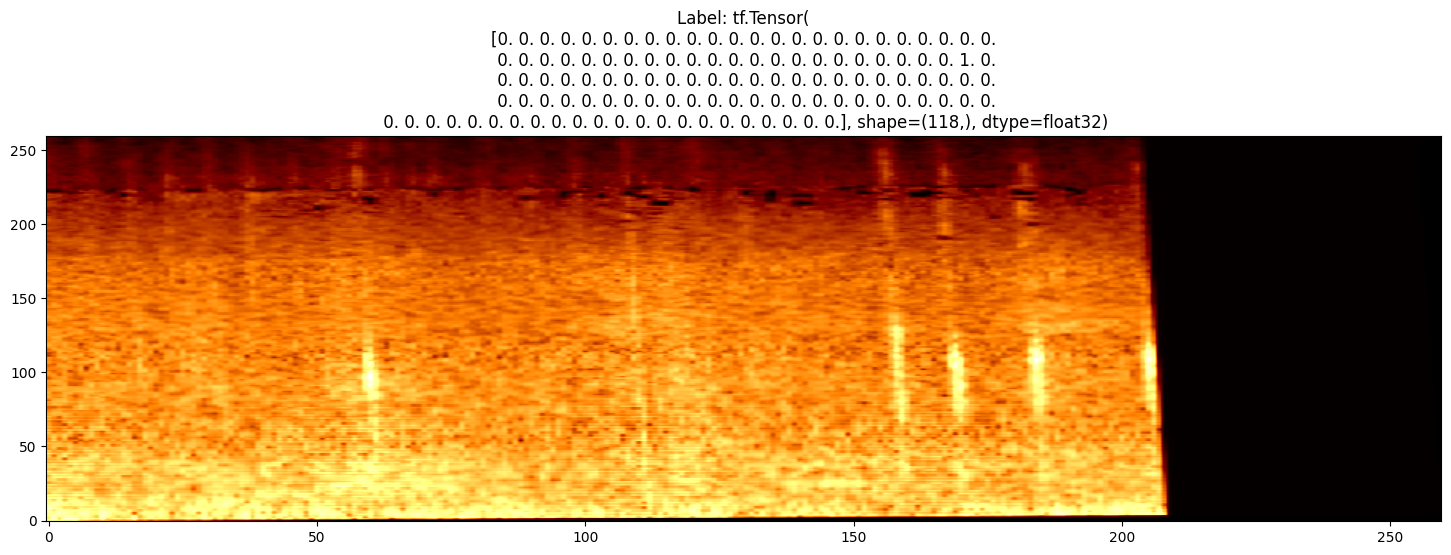

In [19]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

In [20]:
def build_model(trainable):
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 SC['MODEL_INPUT_IMAGE_WIDTH'], 
                 SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [21]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

# load the model if a save file already exists
if os.path.exists('models/echo_model/1/'):
    print("Model already exists, skipping model building and training")
    pass
# If no model can be loaded build the model and save to file 
else:
    if not os.path.exists('models/'):
        os.mkdir('models/')
    if not os.path.exists('models/1'):
        os.mkdir('models/1')    
    
    model = build_model(True)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  metrics=["accuracy"],
                  )
    
    # tensorboard for visualisation of results
    log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                          histogram_freq=1)
    
    # reduce learning rate to avoid overshooting local minima
    lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.75,
                                                          patience=8, 
                                                          verbose=1,
                                                          mode='min',
                                                          cooldown=0, 
                                                          min_lr=1e-7)
    
    # end the training if no improvement for 16 epochs in a row, then restore best model weights
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=16,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )
    
    # save the best model as it trains..
    mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                               save_best_only=True, 
                                               monitor='val_loss', 
                                               mode='min')
    
    
    cache.clear()
    
    # fit the model to the training set
    @tf.autograph.experimental.do_not_convert
    def train_model():
        model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=SC['MAX_EPOCHS'],
            callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
        )
    
    # Measure training time
    start_time = time.time()  # Start timer
    
    train_model()
    
    end_time = time.time()  # End timer
    
    # Calculate and print elapsed time
    training_time = end_time - start_time
    print(f"Model training time: {training_time:.2f} seconds")

    # Save the full model for use with tensorflow serving
    model.save('models/echo_model/1/', overwrite=True)

TensorFlow version: 2.10.0
TensorFlow Hub version: 0.12.0
Model already exists, skipping model building and training


### Testing the Model on Training Dataset 

The next section of this notebook will demonstrate the application of the classification model to the test dataset. The predicted classes are compared to the true classes of testing audiofiles and the accuracy of the model is calculated to ensure confidence in the model's performance before testing on real-world data. 

In [23]:
# Load the saved model
model = tf.keras.models.load_model(r"C:\Project-Echo\src\Prototypes\engine\Testing on Real World Data\models\echo_model\1")

In [24]:
# Load saved data splits 
train_ds, val_ds, test_ds, class_names = create_datasets(
    SC['AUDIO_DATA_DIRECTORY'],
    split_file="./saved_splits/my_split.json"
)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Loading dataset splits from saved file
Class names:  ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates le

In [25]:
# Function to predict class and probability 
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Display class names and run prediction on test dataset
print(f'Class names: {class_names}')

test_results = []

for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions = model.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # Get the true class name using the true index
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        print(f'True class      : {true_class}')
        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')

        test_results.append((None, predicted_class, true_class))

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

In [26]:
# Function to calculate the model accuracy from classification results 
def calculate_accuracy(results):
    correct = 0
    acc = 0
    try:
        for file_name, predicted_class, true_class in results:
            if predicted_class == true_class:
                correct += 1
        acc = ((correct / len(results)) * 100)
    except Exception as e:
            print(f"Error processing file: {e}")
    return acc

In [27]:
print(f"Model Accuracy:")
# calculate and print the model accuracy 
print(calculate_accuracy(test_results))

Model Accuracy:
98.68421052631578


### Testing the Model on Real-World Data

The model will now be testing on real-world audio samples. The audio currently available for testing is not labelled, so the true class of vocalisations is not currently known.

In [29]:
# Function to split audiofiles into 2 second intervals and save them to file
def split_audio_files(input_directory, output_directory, segment_duration=2.0):
    
    os.makedirs(output_directory, exist_ok=True)

    audio_files = [f for f in os.listdir(input_directory) if f.endswith((".wav", ".mp3"))]

    for filename in audio_files:
        file_path = os.path.join(input_directory, filename)
        y, sr = librosa.load(file_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        
        # Split audiofiles into 2 second segments
        num_segments = int(total_duration // segment_duration)
        for i in range(num_segments):
            start_sample = int(i * segment_duration * sr)
            end_sample = int((i + 1) * segment_duration * sr)
            segment = y[start_sample:end_sample]
            
            output_filename = f"{os.path.splitext(filename)[0]}_part{i+1}.wav"
            output_path = os.path.join(output_directory, output_filename)
            sf.write(output_path, segment, sr)
    
    return f"Saved split audio files to: {output_directory}"

# Split and save a sample of real-world audio
input_dir = "C:/Project-Echo/src/Prototypes/engine/Testing on Real World Data/Sample"
output_dir = "C:/Project-Echo/src/Prototypes/engine/Testing on Real World Data/Sample_Segments"

split_audio_files(input_dir, output_dir)

'Saved split audio files to: C:/Project-Echo/src/Prototypes/engine/Testing on Real World Data/Sample_Segments'

In [30]:
# Function to create the unlabeled dataset and convert audio to spectrograms
def create_unlabeled_dataset_from_audio_files(audio_directory_path, batch_size=16, dummy_class_name="animal"):
    # Get the list of audio files
    audio_files = [f for f in os.listdir(audio_directory_path) if f.endswith((".wav", ".mp3"))]
    
    # Define a function to convert audio to spectrogram
    def audio_to_spectrogram(audio_path):
        # Load audio file
        y, sr = librosa.load(audio_path, sr=None)
        
        # Convert to spectrogram
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=260, fmax=8000)
        
        # Resize 
        spectrogram = np.expand_dims(spectrogram, axis=-1)  # Add channel dimension
        spectrogram = np.repeat(spectrogram, 3, axis=-1)    # Duplicate the channel to make it 3 channels
        
        # Normalize spectrogram
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Resize 
        spectrogram = np.resize(spectrogram, (260, 260, 3))  # Resize to the expected shape
        
        return spectrogram

    # Load audio files and assign a dummy label
    audio_paths = []
    dummy_labels = []
    
    for filename in audio_files:
        file_path = os.path.join(audio_directory_path, filename)
        audio_paths.append(file_path)  # Store the audio file path
        dummy_labels.append(0)  # Assign a dummy label
    
    # Convert the audio files to spectrograms
    spectrograms = [audio_to_spectrogram(path) for path in audio_paths]
    
    # One-hot encode dummy labels
    num_classes = 118 
    dummy_labels = tf.constant(dummy_labels)  
    one_hot_labels = tf.one_hot(dummy_labels, depth=num_classes)  
    
    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((spectrograms, one_hot_labels))
    dataset = dataset.batch(batch_size)
    
    return dataset

real_world_audio_directory = "C:/Project-Echo/src/Prototypes/engine/Testing on Real World Data/Sample_Segments/"
real_world_ds = create_unlabeled_dataset_from_audio_files(real_world_audio_directory)

In [31]:
# Function to predict the class of audio files
def predict_class(predictions, class_names):
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    predicted_class = class_names[predicted_index]
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

print(f'Class names: {class_names}')

# Run the model to predict real-world data
for audio_batch, _ in real_world_ds:  
    batch_predictions = model(audio_batch, training=False)
    
    for i in range(batch_predictions.shape[0]):
        predicted_class, predicted_probability = predict_class(batch_predictions[i], class_names)
        print(f"Prediction for audio sample {i+1}: {predicted_class}")
        print(f"Predicted probability: {predicted_probability}%")
        print("---")

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p